# Visualizing Word Vectors with t-SNE

TSNE is pretty useful when it comes to visualizing similarity between objects. It works by taking a group of high-dimensional (100 dimensions via Word2Vec) vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words. 

### Steps

1. Clean the data
2. Build a corpus
3. Train a Word2Vec Model
4. Train XGBoost and logReg

Credit: Some of the code was inspired by this awesome [NLP repo][1]. 




  [1]: https://github.com/rouseguy/DeepLearningNLP_Py

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
from nltk import ngrams

from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from gensim.models import word2vec

#from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import multiprocessing as mp
import timeit


In [3]:
%%time
#data = pd.read_csv('data/train.csv').sample(50000, random_state=23)
data = pd.read_csv('data/train.csv')

CPU times: user 1.88 s, sys: 332 ms, total: 2.21 s
Wall time: 2.47 s


In [12]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [5]:
data_ar = np.array(data)

In [17]:
data_ar[0,:]
np.apply_along_axis(lambda x: x[3].split(), axis=1, arr=data_ar[0:10,:])

ValueError: could not broadcast input array from shape (8) into shape (14)

In [19]:
np.array([1,2,3, ['asd asd asd']])

ValueError: setting an array element with a sequence

In [149]:
%%time
STOP_WORDS = nltk.corpus.stopwords.words()
regex = re.compile('([^\s\w]|_)+')

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

#data = clean_dataframe(data)
#data.head(5)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 103 ms


In [150]:
def multProc(f, data):
    try:
        p = mp.Pool(processes=6)
        split = np.array_split(data, 8)
        res = p.map(f, split)
    finally:
        p.close()
    return res

In [151]:
%time
data = pd.concat(multProc(clean_dataframe, data))

In [152]:
%%time
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split()
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]

CPU times: user 2.8 s, sys: 608 ms, total: 3.41 s
Wall time: 3.39 s


In [ ]:
len(corpus)

In [ ]:
for sentence in data['question1'][1:10].iteritems():
    print(sentence)

# Word 2 Vec

The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this example)

In [108]:
model_w2v = word2vec.Word2Vec(corpus, size=100, window=20, min_count=1, workers=4)

In [153]:
def auc_plot(y_true, y_pred):
    loss = metrics.log_loss(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc=metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend(loc="lower right")
    plt.show()
    return loss, roc_auc 

In [155]:
%%time
def calc_cosine_similir(q1, q2):
    if len(q1) == 0 or len(q2) ==0:
        return 0
    v1 = np.sum([model_w2v.wv[w] for w in q1], axis = 0)
    v2 = np.sum([model_w2v.wv[w] for w in q2], axis = 0)
    res = np.dot(v1, v2) / ( np.sqrt(np.dot(v1, v1)) * np.sqrt(np.dot(v2, v2)) )
    if type(res) != np.dtype('float32'):
        print(type(res))
        print(q1,q2,v1,v2)
        raise
    return res


def calc_counters_from_list(l):
    n = len(l)
    if n == 0:
        return [0.0] * 10
    l = [np.sum(l),
         np.min(l),
         np.max(l),
         np.median(l),
         np.average(l)]
    return l + [x/n for x in l]
    
    
def calc_w2v_similarity(row):
    q1 = row['question1'].split() 
    q2 = row['question2'].split()
    cosine_similir = calc_cosine_similir(q1, q2)
    q1_uniq = list(set(q1) - set(q2)) 
    q2_uniq = list(set(q2) - set(q1))
    words_simil = []
    for w1 in q1_uniq:    
        for w2 in q2_uniq:
            s = model_w2v.similarity(w1, w2)
            words_simil.append(s)
    feat_count = calc_counters_from_list(words_simil)
    return [cosine_similir] + calc_counters_from_list(words_simil)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.6 µs


In [156]:
%%time
# Parallel run

def f(x):
    return np.vstack(x.apply(lambda row: calc_w2v_similarity(row), axis=1))
X_w2v = np.vstack(multProc(f, data))

CPU times: user 1.85 s, sys: 912 ms, total: 2.76 s
Wall time: 5min 53s


In [157]:
%%time
def calc_common_len_ratio(list1, list2):
    """Calculate number of common elements in lists.
    Return list with number and ratio.
    """
    common_unigrams_len = len( set(list1).intersection(set(list2)) )
    common_unigrams_ratio = float(common_unigrams_len) / max(len( set(list1).union(set(list2)) ),1)
    return [common_unigrams_len, common_unigrams_ratio]


def feature_extraction(row):
    unigrams_que1 = row['question1'].split() 
    unigrams_que2 = row['question2'].split()
    out_list = calc_common_len_ratio(unigrams_que1, unigrams_que2)
    
    # get bigram and trigram features #
    for ngr_numb in [2,3]:
        q1_ngram = [i for i in ngrams(unigrams_que1, ngr_numb)]
        q2_ngram = [i for i in ngrams(unigrams_que2, ngr_numb)]
        out_list = out_list + calc_common_len_ratio(q1_ngram, q2_ngram)
    return out_list
#X_common_old = np.array(data.apply(lambda row: feature_extraction(row), axis=1, raw=True))

def f(x):
    return np.array(x.apply(lambda row: feature_extraction(row), axis=1, raw=True))

X_common = np.vstack(multProc(f, data))


/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/dm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:

CPU times: user 1.57 s, sys: 644 ms, total: 2.22 s
Wall time: 3min 44s


In [158]:
X = np.c_[X_common, X_w2v]

In [159]:
from sklearn.model_selection import train_test_split
y = data.is_duplicate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [160]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=0.5,
                   fit_intercept=True, intercept_scaling=1, class_weight=None,
                   random_state=42, solver='liblinear', max_iter=100,
                   multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:,1]

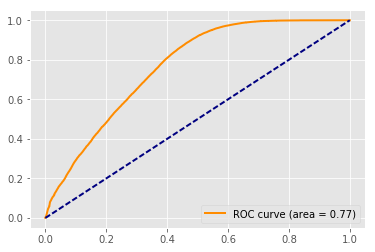

(0.53298479364626472, 0.76564210183473125)

In [161]:
auc_plot(y_test, y_pred)

[('min', 0.073439792714595706),
 ('min_norm', -0.14795109658762412),
 ('cosine_similir', 0.26469094308025559),
 ('max', -0.48038486532915614),
 ('median', -0.61145658671042213),
 ('avg_norm', -0.68778058010071108),
 ('median_norm', -1.0112172866645373),
 ('sum', 1.0780675426051733),
 ('avg', 1.1709111705847135),
 ('max_norm', 1.2876169350718158),
 ('sum_norm', 2.499255669975772)]

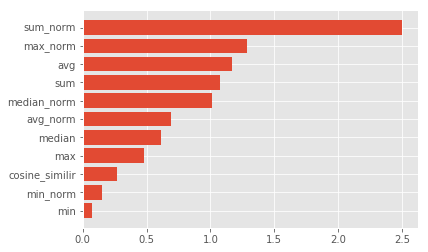

In [140]:
coef_names = ['sum', 'min', 'max', 'median', 'avg']
coef_names = ['cosine_similir'] + coef_names + [x + '_norm' for x in coef_names]

logreg_coef = sorted([(x, y) for x,y in zip(coef_names, clf.coef_[0])],
       key=lambda tup: np.abs(tup[1]))

label = [x for x, _ in logreg_coef]
val = [x for _, x  in logreg_coef]
groups = len(val)
fig, ax = plt.subplots()
plt.barh(range(groups), np.abs(val),
                 label='Men')
plt.yticks(np.arange(groups), label)
logreg_coef

In [142]:
print(data.iloc[1,:])
q=data.iloc[1,:]['question1'].split()
v1 = np.sum([model_w2v.wv[w] for w in q], axis = 0)
q=data.iloc[1,:]['question2'].split() 
v2 = np.sum([model_w2v.wv[w] for w in q], axis = 0)
np.dot(v1, v2) / ( np.sqrt(np.dot(v1, v1)) * np.sqrt(np.dot(v2, v2)) )

id                                                              1
qid1                                                            3
qid2                                                            4
question1                         story kohinoor kohinoor diamond
question2       would happen indian government stole kohinoor ...
is_duplicate                                                    0
Name: 1, dtype: object


0.13287671

[0]	train-logloss:0.687311	test-logloss:0.687355
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 25 rounds.
[50]	train-logloss:0.549367	test-logloss:0.55065
[100]	train-logloss:0.511062	test-logloss:0.512903
[150]	train-logloss:0.497534	test-logloss:0.499718
[200]	train-logloss:0.491668	test-logloss:0.494088
[250]	train-logloss:0.488914	test-logloss:0.49152
[300]	train-logloss:0.486881	test-logloss:0.489649
[350]	train-logloss:0.485205	test-logloss:0.488164
[400]	train-logloss:0.483921	test-logloss:0.487027
[450]	train-logloss:0.482731	test-logloss:0.48598
[500]	train-logloss:0.481793	test-logloss:0.48518
[550]	train-logloss:0.481064	test-logloss:0.484603
[600]	train-logloss:0.48039	test-logloss:0.484068
[650]	train-logloss:0.479686	test-logloss:0.483524
[700]	train-logloss:0.478997	test-logloss:0.48299
[750]	train-logloss:0.478458	test-logloss:0.48261
[800]	train-logloss:0.477954	test-logloss:0.4

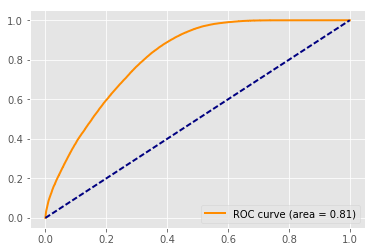

(0.48096558855722787, 0.81372010910499193)

In [144]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 25
params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["silent"] = 1
params["seed"] = 42
num_rounds = 1000 
plst = list(params.items())
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
model = xgb.train(plst, xgtrain, num_rounds, watchlist,
                  early_stopping_rounds=25, verbose_eval=50)
y_pred = model.predict(xgtest)
auc_plot(y_test, y_pred)

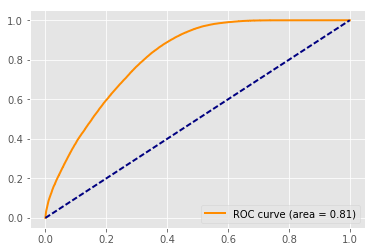

(0.48096558855722787, 0.81372010910499193)

In [145]:
y_pred = model.predict(xgtest)
auc_plot(y_test, y_pred)

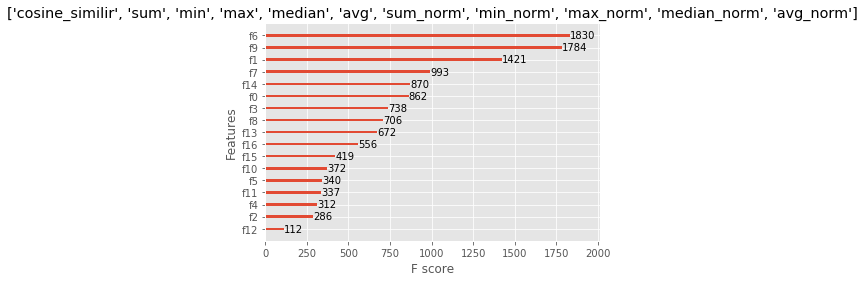

In [146]:
xgb.plot_importance(model,  title=coef_names)